In [196]:
from pprint import pprint
from time import time
import logging
import pandas as pd 
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn import ensemble, naive_bayes
import xgboost as xgb
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns

print(__doc__)

%matplotlib inline

Automatically created module for IPython interactive environment


In [105]:
pd.options.mode.chained_assignment=None

In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [106]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


pipeline_with_SGDClassifier.ipynb
train.csv



In [374]:
df = pd.read_csv('../input/train.csv')


In [375]:
test = pd.read_csv('../input/test.csv')

In [376]:
eng_stop = set(stopwords.words('English'))

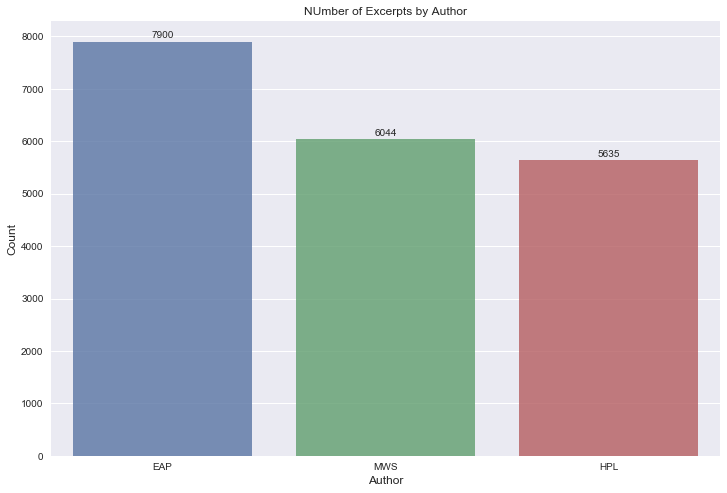

In [377]:
# Calculate and display the break down of works by author
authors_works = df['author'].value_counts()
values = authors_works.values

plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.barplot(authors_works.index,authors_works.values, alpha=0.8)
ax.set_xlabel('Author', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('NUmber of Excerpts by Author')
ax.set_xticklabels(authors_works.index)

rects = ax.patches

for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 200, val, ha='center', va='top')

In [378]:
# Investigate writing style of each author
authors= df.groupby('author')
for name, group in authors:
    print("Author name : ", name)
    count = 0
    for ind, row in group.iterrows():
        print(row["text"])
        count += 1
        if count == 5:
            break
    print("\n")
    

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

# Meta Attributes

In [111]:
# Number of word
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

In [112]:
#Unique words
df['uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
test['uniq_words'] = test['text'].apply(lambda x: len(set(str(x).split())))

In [113]:
# Number of characters in text
df['num_char'] = df['text'].apply(lambda x: len(str(x)))
test['num_char'] = test['text'].apply(lambda x: len(str(x)))

In [117]:
# Number of stop words
df['num_stops'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stop]))
test['num_stops'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stop]))
                                   

In [120]:
df['punct_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punct_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [121]:
# NUmber of upper case words
df['upper_case'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test['upper_case'] = test['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [122]:
# number of title case words
df['title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test['title'] = test['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [125]:
# average length of word
df['avg_len']= df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['avg_len']= test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [299]:
df['word_count'].max()

861

In [126]:
df.head()

,id,text,author,word_count,uniq_words,num_char,num_stops,punct_count,upper_case,title,avg_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481


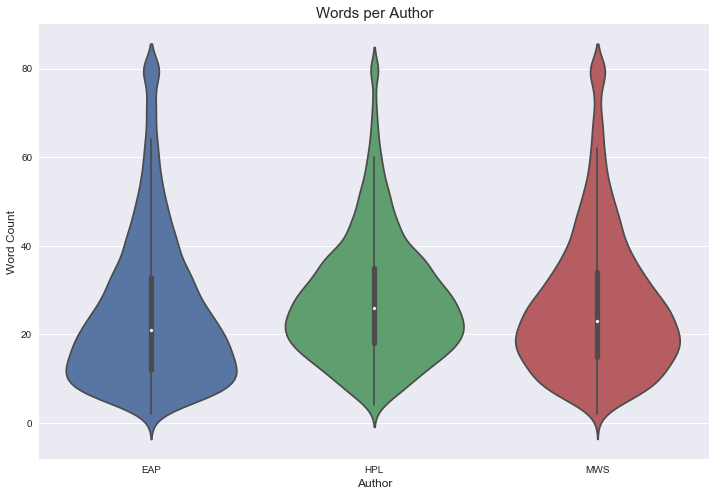

In [128]:
df['word_count'].loc[df['word_count']>80]=80
plt.figure(figsize=(12,8))
sns.violinplot(x= 'author', y='word_count', data=df)
plt.ylabel('Word Count', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Words per Author', fontsize=15)


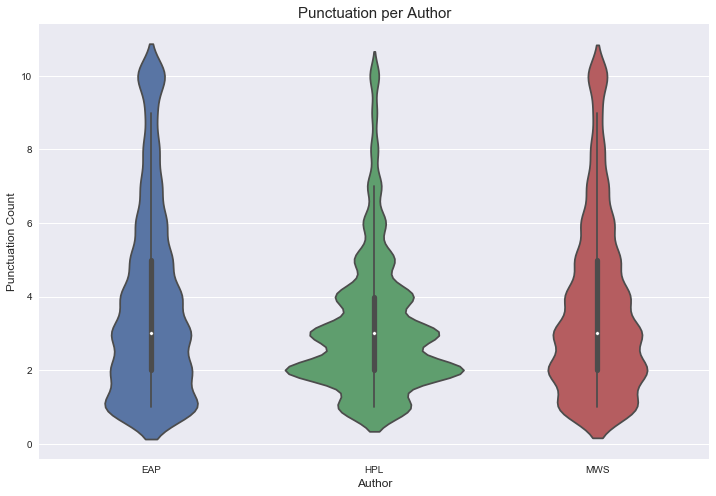

In [129]:
df['punct_count'].loc[df['punct_count']>10]=10
plt.figure(figsize=(12,8))
sns.violinplot(x= 'author', y='punct_count', data=df)
plt.ylabel('Punctuation Count', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Punctuation per Author', fontsize=15)


In [134]:
# Label encode the target variable, auhtor
encoder = LabelEncoder()
encoder.fit(df['author'])
y=encoder.transform(df['author'])
df_id = df['id'].values
test_id = test['id'].values

In [135]:
#recomputed truncated variables
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

df['punct_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punct_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [136]:
df.head()

,id,text,author,word_count,uniq_words,num_char,num_stops,punct_count,upper_case,title,avg_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481


In [141]:
cols= ['id', 'text']
X = df.drop(cols + ['author'], axis =1)
test_X = test.drop(cols, axis=1)

In [162]:
def RunXGB(train_X, train_y, test_X,test_y, test_X2=None, seed_val=0, child=1, colsample=.3):
    param= {}
    param['objective'] = 'multi:softprob'
    param['eta'] = .1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = child
    param['subsample'] = .8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plist =list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label= test_y)
        watchlist = [ (xgtrain, 'train', xgtest, 'test') ]
        model = xgb.train(plist, xgtrain, num_rounds, watchlist, early_stopping_rounds =50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plist, xgtrain,num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [166]:
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores=[]
pred_full_test=0
pred_train= np.zeros([df.shape[0], 3])
for dev_index, val_index in kf.split(X):
    dev_X, val_X =X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = RunXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('cv scores:', cv_scores)

[0]	train-mlogloss:1.09449
Will train until train-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04427
[40]	train-mlogloss:1.02323
[60]	train-mlogloss:1.00778
[80]	train-mlogloss:0.995157
[100]	train-mlogloss:0.987575
[120]	train-mlogloss:0.980675
[140]	train-mlogloss:0.974948
[160]	train-mlogloss:0.969861
[180]	train-mlogloss:0.965261
[200]	train-mlogloss:0.961013
[220]	train-mlogloss:0.957292
[240]	train-mlogloss:0.954248
[260]	train-mlogloss:0.951133
[280]	train-mlogloss:0.94726
[300]	train-mlogloss:0.94414
[320]	train-mlogloss:0.940747
[340]	train-mlogloss:0.937666
[360]	train-mlogloss:0.935134
[380]	train-mlogloss:0.932375
[400]	train-mlogloss:0.929979
[420]	train-mlogloss:0.927369
[440]	train-mlogloss:0.925031
[460]	train-mlogloss:0.922406
[480]	train-mlogloss:0.92049
[500]	train-mlogloss:0.918572
[520]	train-mlogloss:0.916769
[540]	train-mlogloss:0.914808
[560]	train-mlogloss:0.912887
[580]	train-mlogloss:0.911083
[600]	train-mlogloss:0.909437
[620]	train-mlogloss:

[1320]	train-mlogloss:0.862466
[1340]	train-mlogloss:0.861358
[1360]	train-mlogloss:0.860352
[1380]	train-mlogloss:0.859251
[1400]	train-mlogloss:0.858224
[1420]	train-mlogloss:0.857235
[1440]	train-mlogloss:0.85639
[1460]	train-mlogloss:0.85546
[1480]	train-mlogloss:0.854602
[1500]	train-mlogloss:0.853685
[1520]	train-mlogloss:0.852807
[1540]	train-mlogloss:0.851958
[1560]	train-mlogloss:0.85101
[1580]	train-mlogloss:0.850135
[1600]	train-mlogloss:0.849216
[1620]	train-mlogloss:0.84833
[1640]	train-mlogloss:0.847314
[1660]	train-mlogloss:0.846429
[1680]	train-mlogloss:0.845609
[1700]	train-mlogloss:0.844859
[1720]	train-mlogloss:0.84418
[1740]	train-mlogloss:0.843382
[1760]	train-mlogloss:0.842633
[1780]	train-mlogloss:0.841813
[1800]	train-mlogloss:0.841072
[1820]	train-mlogloss:0.840253
[1840]	train-mlogloss:0.839378
[1860]	train-mlogloss:0.838371
[1880]	train-mlogloss:0.837602
[1900]	train-mlogloss:0.836889
[1920]	train-mlogloss:0.836093
[1940]	train-mlogloss:0.835346
[1960]	train-

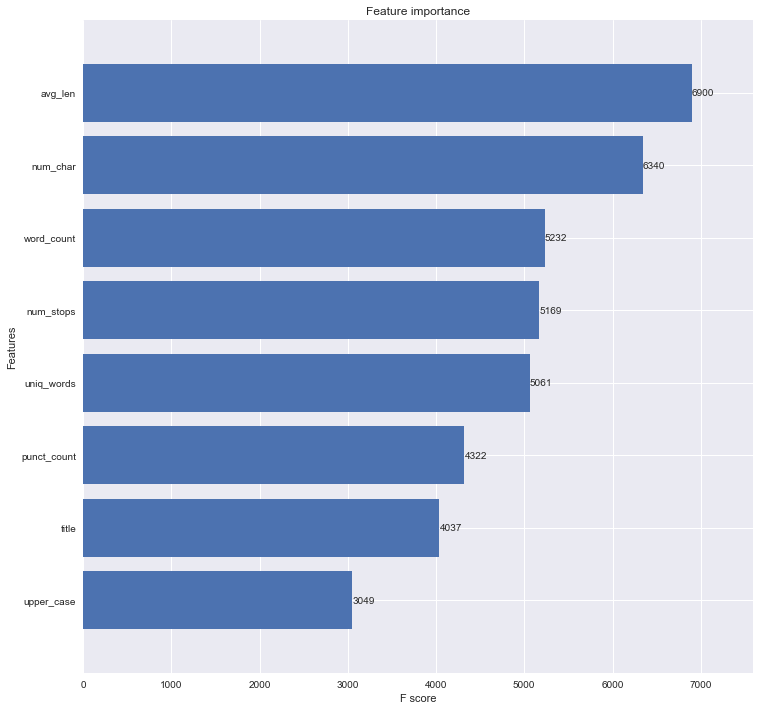

In [169]:
# plot the imporant variables
fig, ax =plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=.8, ax=ax)

In [302]:
# Tfidf
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
complete_tfidf= tfidf.fit_transform(df['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf.transform(df['text'].values.tolist())
test_tfidf = tfidf.transform(test['text'].values.tolist())


In [191]:
# Multinomial naive Bayes model
def runMNB (train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model


In [193]:
kf = KFold(n_splits=5, shuffle=True, random_state=2017) # Instantiate kfold split
cv_scores=[] # Empty list to hold cross validation scores
pred_full_test=0  # Intialize the value of the predictionof the entire dataframe
pred_train= np.zeros([df.shape[0], 3])  #Define a numpy array of zeros 
for dev_index, val_index in kf.split(X):  # Define value of train and test indices
    dev_X, val_X =train_tfidf[dev_index], train_tfidf[val_index]  # Define train and test rows for features
    dev_y, val_y = y[dev_index], y[val_index]  # Define train and test rows for target 
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf) # Instantiate function model run attaining predict proba values for target variables for train and test
    pred_full_test = pred_full_test + pred_test_y # sum values of individual predict probas for full dataset predict proba value
    pred_train[val_index,:] = pred_val_y  # Insert predict values into prediciton dataframe
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))  # Calculate log loss of model 
print('Mean cv score:' , np.mean(cv_scores))
pred_full_test = pred_full_test/5.

Mean cv score: 0.842216198361


In [304]:
n_comp = 20
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd.fit(complete_tfidf)
train_svd = pd.DataFrame(svd.transform(train_tfidf))
test_svd = pd.DataFrame(svd.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([df, train_svd], axis=1)
test_df = pd.concat([test, test_svd], axis=1)
del complete_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [305]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(df['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [329]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([df.shape[0], 3])
kf =KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.450918416166


In [330]:
df['nb_cvec_eap'] = pred_train[:,0]
df['nb_cvec_hpl'] = pred_train[:,1]
df['nb_cvec_mws'] = pred_train[:,2]
test['nb_cvec_eap'] = pred_full_test[:,0]
test['nb_cvec_hpl'] = pred_full_test[:,1]
test['nb_cvec_mws'] = pred_full_test[:,2]


In [340]:
# Naive Bayes character countvectorizer
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(df['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

cv_scores = [] 
pred_full_test = 0
for dev_index, val_index in kf.split(X):
    dev_X,val_X= train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv scores:', np.mean(cv_scores))
pred_full_test = pred_full_test/5

Mean cv scores: 3.75076392268


In [349]:
full_tfidf = tfidf_vec.fit_transform(df['text'].values.tolist() + test['text'].values.tolist())

In [341]:
df['nb_char_cvec_eap'] = pred_train[:,0]
df['nb_char_cvec_hpl'] = pred_train[:,1]
df['nb_char_cvec_mws'] = pred_train[:,2]
test['nb_char_cvec_eap'] = pred_full_test[:,0]
test['nb_char_cvec_hpl'] = pred_full_test[:,1]
test['nb{char_cvec_mws'] = pred_full_test[:,2]

In [368]:
test['nb{char_cvec_mws']  = test['nb{char_cvec_mws'].rename('nb_char_cvec_mws')

In [371]:
test.shape

(8392, 56)

In [343]:
df.shape

(19579, 9)

In [352]:
#Naive Bayes on character TFIDF
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(df['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(df['text'].values.tolist())
test_tfidf =tfidf_vec.transform(test['text'].values.tolist())

cv_scores = []
pred_full_test =0
for dev_index, val_index in kf.split(X):
    dev_X, val_X = train_tfidf[dev_index],train_tfidf[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test= pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv scores:', np.mean(cv_scores))
pred_full_test = pred_full_test/5

Mean cv scores: 0.790415258947


In [353]:
df['nb_char_tfidf_eap'] = pred_train[:,0]
df['nb_char_tfidf_hpl']= pred_train[:,1]
df['nb_char_tfidf_mws'] =pred_train[:,2]
test['nb_char_tfidf_eap'] = pred_full_test[:,0]
test['nb_char_tfidf_hpl']= pred_full_test[:,1]
test['nb_char_tfidf_mws'] =pred_full_test[:,2]


In [357]:
# SVD on charcter TFIDF
n_comps=20
svd = TruncatedSVD(n_components=n_comps, algorithm='arpack')
svd.fit(full_tfidf)
train_svd = pd.DataFrame(svd.transform(train_tfidf))
test_svd = pd.DataFrame(svd.transform(test_tfidf))

train_svd.columns = ['svd_char_' +str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char' +str(i) for i in range(n_comp)]
df = pd.concat([df, train_svd], axis=1)
test = pd.concat([test, test_svd], axis =1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [358]:
df.shape

(19579, 52)

In [372]:
# Xgboost model
cols= ['id', 'text']
X = df.drop(cols + ['author'], axis =1)
test_X = test.drop(cols, axis=1)

cv_scores=[]
pred_full_test =0
pred_train = np.zeros([df.shape[0],3])
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index],X.loc[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = RunXGB(dev_X, dev_y, val_X, val_y,test_X,seed_val=0, colsample=0.7)
    pred_full_test= pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv scores:', np.mean(cv_scores))
pred_full_test = pred_full_test/5

ValueError: feature_names must be unique

In [373]:
for col in X.columns:
    print(col)

nb_cvec_eap
nb_cvec_hpl
nb_cvec_mws
nb_char_cvec_eap
nb_char_cvec_hpl
nb{char_cvec_mws
nb_char_tfidf_eap
nb_char_tfidf_hpl
nb_char_tfidf_mws
svd_char_0
svd_char_1
svd_char_2
svd_char_3
svd_char_4
svd_char_5
svd_char_6
svd_char_7
svd_char_8
svd_char_9
svd_char_10
svd_char_11
svd_char_12
svd_char_13
svd_char_14
svd_char_15
svd_char_16
svd_char_17
svd_char_18
svd_char_19
svd_char_0
svd_char_1
svd_char_2
svd_char_3
svd_char_4
svd_char_5
svd_char_6
svd_char_7
svd_char_8
svd_char_9
svd_char_10
svd_char_11
svd_char_12
svd_char_13
svd_char_14
svd_char_15
svd_char_16
svd_char_17
svd_char_18
svd_char_19


In [366]:
X.drop('nb{char_cvec_mws', axis=1, inplace =True)

In [328]:
mnb= naive_bayes.MultinomialNB()
mnb.fit(train_tfidf, y)
mnb.predict_proba(test_tfidf)

array([[  1.34173008e-02,   3.04175039e-04,   9.86278524e-01],
       [  9.99993116e-01,   4.13025385e-06,   2.75334513e-06],
       [  1.86976760e-01,   8.12950429e-01,   7.28115927e-05],
       ..., 
       [  9.99999990e-01,   2.39606690e-09,   7.77945800e-09],
       [  2.87410711e-04,   1.78779466e-06,   9.99710801e-01],
       [  8.13587955e-03,   9.91862475e-01,   1.64544230e-06]])

In [320]:
eap=[]
hpl=[]
mws=[]
for row in mnb.predict_proba(test_tfidf):
    eap.append(row[0])
    hpl.append(row[1])
    mws.append(row[2])

test['EAP']=eap
test['HPL'] = hpl
test['MWS']=mws

In [323]:
submission = test[['id', 'EAP', 'HPL', 'MWS']]
submission.to_csv('spooky_authors3.csv', index=False)